In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Ruta del archivo CSV
csv_path = "dataset_final_2.csv"

# Cargar el DataFrame
df_rnn_final = pd.read_csv(csv_path)

# Normalizar la columna rating en valores entre 0 y 1
df_rnn_final['rating'] = (df_rnn_final['rating'] - df_rnn_final['rating'].min()) / (df_rnn_final['rating'].max() - df_rnn_final['rating'].min())

# Mostrar primeras filas para verificar
df_rnn_final.head()

,userId,movieId,temporal_1,temporal_2,temporal_3,rating,timestamp,is_weekend,season_encoded,is_holiday,year,month,weekday,consumo_semanal_usuario
0,1,541,6.076570,1.968400,4.461806,1.000000,943227521,1,3,0,1999,11,6,3
1,1,166,6.072158,1.971917,4.457658,1.000000,943228442,1,3,0,1999,11,6,3
2,1,1784,6.075465,1.968327,4.461445,0.111111,943228545,1,3,0,1999,11,6,3
3,1,1944,-6.705580,17.750286,3.588970,0.333333,943231120,0,3,0,1999,11,0,3
4,1,1208,-6.705580,17.750286,3.588970,1.000000,943231192,0,3,0,1999,11,0,3


In [3]:
# Conservar las columnas userId, movieId, rating, timestamp, temporal_1, temporal_2, temporal_3
df_rnn_final = df_rnn_final[['userId', 'movieId', 'rating', 'temporal_1', 'temporal_2', 'temporal_3']]
df_rnn_final.head()

,userId,movieId,rating,temporal_1,temporal_2,temporal_3
0,1,541,1.000000,6.076570,1.968400,4.461806
1,1,166,1.000000,6.072158,1.971917,4.457658
2,1,1784,0.111111,6.075465,1.968327,4.461445
3,1,1944,0.333333,-6.705580,17.750286,3.588970
4,1,1208,1.000000,-6.705580,17.750286,3.588970


In [4]:
# mostrar los valores unicos de la columns rating
df_rnn_final['rating'].unique()

array([1.        , 0.11111111, 0.33333333, 0.55555556, 0.77777778,
       0.66666667, 0.44444444, 0.88888889, 0.        , 0.22222222])

In [5]:
# Seleccionar solo las columnas numéricas que usaremos como input
features_columns = [
    'userId', 'movieId',
    'temporal_1', 'temporal_2', 'temporal_3'
]

# Opcional: agrega rating_previous si lo calculaste
# features_columns.append('rating_previous')

X = df_rnn_final[features_columns].values
y = df_rnn_final['rating'].values  # El objetivo a predecir
from collections import defaultdict

# Diccionario para guardar secuencias por usuario
user_sequences = defaultdict(list)
user_targets = defaultdict(list)

# Recorremos todo el dataset y vamos guardando por usuario
for idx, row in df_rnn_final.iterrows():
    user_id = row['userId']
    x = row[features_columns].values
    target = row['rating']

    user_sequences[user_id].append(x)
    user_targets[user_id].append(target)


In [6]:

# Convertimos a listas
sequences_list = list(user_sequences.values())
targets_list = np.array([np.mean(t) for t in user_targets.values()])  # promedio del rating del usuario, o puedes usar último valor

# Padding (rellenar con ceros al inicio)
maxlen = 50  # Máximo 50 interacciones por usuario
X_padded = pad_sequences(sequences_list, maxlen=maxlen, padding='pre', dtype='float32')

print("Forma de X_padded:", X_padded.shape)
print("Forma de y:", targets_list.shape)



X_train, X_test, y_train, y_test = train_test_split(X_padded, targets_list, test_size=0.2, random_state=42)



Forma de X_padded: (200384, 50, 5)
Forma de y: (200384,)


c:\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 50, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.2665 - mae: 0.3397 - val_loss: 0.0171 - val_mae: 0.1011
Epoch 2/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 0.0191 - mae: 0.1074 - val_loss: 0.0168 - val_mae: 0.0998
Epoch 3/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0169 - mae: 0.1001 - val_loss: 0.0168 - val_mae: 0.0997
Epoch 4/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0168 - mae: 0.0997 - val_loss: 0.0168 - val_mae: 0.0995
Epoch 5/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0169 - mae: 0.0998 - val_loss: 0.0167 - val_mae: 0.0995
Epoch 6/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0168 - mae: 0.0995 - val_loss: 0.0169 - val_mae: 0.0997
Epoch 7/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 0.0168 - mae: 0.0999 - val_loss: 0.0168 - val_mae: 0.0999
Epoch 8/15
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 0.0169 - mae: 0.1000 - val_loss: 0.0170 - val_mae: 0.1010
Epoch 9/15
2505/2505 ━━━

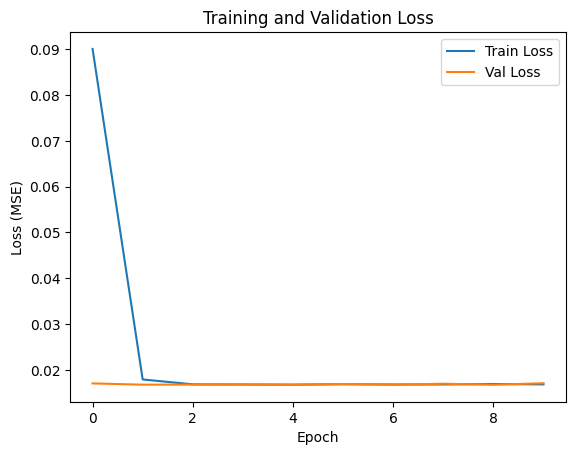

Modelo guardado como 'rnn_rating_model.h5'


In [7]:


# Parámetros del modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # maxlen, n_features
lstm_units = 64
dropout_rate = 0.4
learning_rate = 0.001

# Construcción del modelo
model = Sequential()

# Opcional: Capa Masking si usas padding ('mask_zero=True' en Embedding o aquí)
model.add(Masking(mask_value=0., input_shape=input_shape))

# Capa LSTM
model.add(LSTM(units=lstm_units, return_sequences=False))  # False porque solo queremos 1 salida por secuencia
model.add(Dropout(dropout_rate))

# Capa densa final para regresión
model.add(Dense(units=1, activation='linear'))  # Salida lineal para predecir el rating

# Compilación del modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse',           # Error cuadrático medio
    metrics=['mae']       # Métrica adicional: error absoluto medio
)

# Mostrar resumen del modelo
model.summary()

# Callback para detener el entrenamiento si deja de mejorar
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluar en test
loss, mae = model.evaluate(X_test, y_test, verbose=0)

# Predecir y calcular RMSE manualmente
y_pred = model.predict(X_test, batch_size=64).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Mostrar resultados finales
print(f"\n✅ Test Loss (MSE): {loss:.4f}")
print(f"✅ Test MAE: {mae:.4f}")
print(f"✅ Test RMSE: {rmse:.4f}")

import matplotlib.pyplot as plt

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Guardar modelo completo
model.save("rnn_rating_model_only_temporals.h5")
print("Modelo guardado como 'rnn_rating_model.h5'")

In [8]:
df_prediccion = pd.read_csv("dataset_final_21.csv")
df_prediccion = df_prediccion[['userId', 'movieId', 'temporal_1', 'temporal_2', 'temporal_3']]
df_prediccion.sort_values(by=['userId', 'movieId'])
df_prediccion.head()

,userId,movieId,temporal_1,temporal_2,temporal_3
0,1,541,6.076570,1.968400,4.461806
1,1,3078,-0.530652,2.521121,2.499882
2,1,838,-0.533817,2.518621,2.497426
3,1,1236,-0.545981,2.506378,2.485310
4,1,2918,-0.524821,2.527317,2.506026


In [9]:
feature_cols = ['userId', 'movieId', 'temporal_1', 'temporal_2', 'temporal_3']

In [10]:
sequences = []
X_pred = []
ids = []

for user_id, group in df_prediccion.groupby('userId'):
    features = group[feature_cols].values
    user_movie_ids = group[['userId', 'movieId']].values

    for i in range(len(features) - 50 + 1):
        seq = features[i:i+50]
        X_pred.append(seq)
        ids.append(user_movie_ids[i+49])  # película objetivo: paso 50

# Convertir a numpy array
X_pred = np.array(X_pred)  # shape: (n_samples, 50, 3)

print("✅ Shape final para predicción:", X_pred.shape)  # (n_samples, 50, 3)


✅ Shape final para predicción: (1580637, 50, 5)


In [11]:
# --- Realizar predicciones ---
preds = model.predict(X_pred, batch_size=64).flatten()

# --- Crear DataFrame con predicciones ---
df_result = pd.DataFrame(ids, columns=['userId', 'movieId'])
df_result['predicted_rating'] = preds

# --- Guardar a CSV ---
df_result.to_csv("predicciones_secuencias_allfeatures.csv", index=False)

print("✅ Archivo 'predicciones_secuencias_allfeatures.csv' creado con", len(df_result), "predicciones.")

24698/24698 ━━━━━━━━━━━━━━━━━━━━ 242s 10ms/step
✅ Archivo 'predicciones_secuencias_allfeatures.csv' creado con 1580637 predicciones.


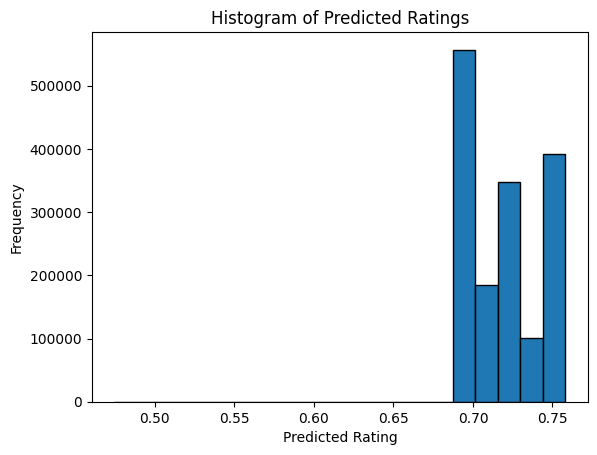

In [12]:
# mostrar un histograma de las predicciones
plt.hist(df_result['predicted_rating'], bins=20, edgecolor='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Ratings')
plt.show()

In [13]:
# mmostrar los maximos y minimos de las predicciones
print("Predicción máxima:", df_result['predicted_rating'].max())
print("Predicción mínima:", df_result['predicted_rating'].min())

Predicción máxima: 0.7581019
Predicción mínima: 0.47454622
